# Ready, Steady, Go AI (*Tutorial*)

This tutorial is a supplement to the paper, **Ready, Steady, Go AI: A Practical Tutorial on Fundamentals of Artificial Intelligence and Its Applications in Phenomics Image Analysis** (*Patterns, 2021*) by Farid Nakhle and Antoine Harfouche

Read the accompanying paper [here](https://doi.org/10.1016/j.patter.2021.100323).

# Table of contents


* **1. Background**
* **2. Downloading Preprocessed Dataset**
* **3. Training DCNN With Transfer Learning**
* **4. Confusion Matrix**

# 1. Background


Before diving into image preprocessing or analysis, it is fundamental to understand how computers process an RGB image. The smallest element in an image is a dot called pixel, which is a mix of R, G, and B colors. Multiple pixels arranged in rows and columns form the image. However, computers do not understand pixels as dots of color, they only understand numbers, and thus, a pixel is denoted as 1 × 3 matrix, representing the three colors R, G, and B with each being an 8-bit integer leading to 256 possible states for every color. These states represent the brightness of each color, with 0 being the darkest and 255 being the brightest. For example, a matrix with values R = 255, G = 255 and B = 255 would lead to a white pixel.

**How does deep convolutional neural network work?**

A DCNN is commonly composed of three main types of layers. The network starts with a convolutional layer which can be followed by additional convolutional or pooling layers and ends with the fully connected layer.
The convolutional layer employs a feature detector, known as a filter or kernel, that moves across an input image and checks for the presence of important features. This operation is known as convolution. A dot product is calculated between the input pixels and the filter, storing the output in a new matrix. Afterwards, the filter shifts by a predefined number of pixels, known as stride, repeating the process until it has swept the entire image. The final output is known as feature map or activation map. After each convolution, a nonlinear activation function is applied to the feature map, such as the rectified linear unit (ReLU) transformation which simply outputs the input directly if it is positive, and zero otherwise.

The pooling layer reduces the number of features in representations captured by convolutional layers. Similarly, it sweeps a filter across the entire input, applying an aggregation function that chooses the maximum (max pooling) or the average (average pooling) value of the input to populate an output matrix.

Finally, the fully connected layer, typically a DNN, performs classification on the features extracted by the series of convolutional and pooling layers.

**What is transfer learning?**

Features learned at different layers of DCNN correspond to different levels of abstractions. For example, initial layers detect edges and extract color information, and the following layers encode shapes and textures. Such learned features can be transferred from one model to another in a process called transfer learning. Transferring knowledge from previously trained models can be more efficient rather than training a DCNN from scratch.

We will transfer knowledge acquired from a pretrained DenseNet-161 model (trained on ImageNet) and use our split, balanced dataset to classify tomato healthy and diseased leafs


# 2. Downloading Preprocessed Dataset

As a reminder, we are working with the PlantVillage dataset, originally obtained from [here](http://dx.doi.org/10.17632/tywbtsjrjv.1).
For this tutorial, we will be working with a subset of PlantVillage, where we will choose the tomato classes only. We have made the subset available [here](http://dx.doi.org/10.17632/4g7k9wptyd.1). 

The next code will automatically download the preprocessed dataset.

**It is important to note that Colab deletes all unsaved data once the instance is recycled. Therefore, remember to download your results once you run the code.**

In [ ]:
import requests
import os
import zipfile

## FEEL FREE TO CHANGE THESE PARAMETERS
dataset_url = "http://faridnakhle.com/pv/tomato-split-cropped-segmented-balanced.zip"
save_data_to = "/content/dataset/tomato-dataset/"
dataset_file_name = "tomato-split-cropped-segmented-balanced.zip"
#######################################

if not os.path.exists(save_data_to):
    os.makedirs(save_data_to)

r = requests.get(dataset_url, stream = True, headers={"User-Agent": "Ready, Steady, Go AI"})

print("Downloading dataset...")  

with open(save_data_to + dataset_file_name, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block)

## Extract downloaded zip dataset file
print("Dataset downloaded")  
print("Extracting files...")  
with zipfile.ZipFile(save_data_to + dataset_file_name, 'r') as zip_dataset:
    zip_dataset.extractall(save_data_to)

## Delete the zip file as we no longer need it
os.remove(save_data_to + dataset_file_name)
print("All done!")  


Dataset downloaded
Extracting files...
All done!


# 3. Training DCNN

We will import PyTorch as we will use it for the implementation of DCNN

In [ ]:
import argparse
import os
import time

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from collections import OrderedDict
import json
!pip install lime
from lime import lime_image


     |████████████████████████████████| 276kB 19.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=0a20719b67087d505e614aa332910c75a48bb67c6944c27bb4073a727707bf2d
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
## YOU CAN CHANGE THESE VARIABLES    
EPOCHS = 100
BATCH_SIZE = 20
LEARNING_RATE = 0.0001
data_dir = '/content/dataset/tomato-dataset/'
save_checkpoints = True
save_model_to = '/content/output/'
!mkdir /content/output/
IMG_SIZE = 220
NUM_WORKERS = 1
using_gpu = torch.cuda.is_available()
print_every = 300
ARCH = 'densenet161'
######################################################

Next, we will define a function that creates a data loader for all of our sets (i.e., training, validation, and testing)

In [ ]:
def data_loader(root, batch_size=256, workers=1, pin_memory=True):
    traindir = os.path.join(root, 'train')
    valdir = os.path.join(root, 'val')
    testdir = os.path.join(root, 'test')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            normalize
        ])
    )
    val_dataset = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            normalize
        ])
    )
    test_dataset = datasets.ImageFolder(
        testdir,
        transforms.Compose([
            transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            normalize
        ])
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=workers,
        pin_memory=pin_memory,
        sampler=None
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers,
        pin_memory=pin_memory
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers,
        pin_memory=pin_memory
    )
    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

In [ ]:
# Data loading
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = data_loader(data_dir, BATCH_SIZE, NUM_WORKERS, False)
print("Training Set: " + str(len(train_loader.dataset)))
print("Validation Set: " + str(len(val_loader.dataset)))
print("Testing Set: " + str(len(test_loader.dataset)))

Training Set: 15228
Validation Set: 1812
Testing Set: 1825


The next code block is the function that creates our algorithm architecture. 

In [ ]:
# Freeze parameters so we don't backprop through them
hidden_layers = [10240, 1024]
def make_model(structure, hidden_layers, lr, preTrained):
    if structure=="densenet161":
        model = models.densenet161(pretrained=preTrained)
        input_size = 2208
    else:
        model = models.vgg16(pretrained=preTrained)
        input_size = 25088
    output_size = 102
    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                              ('dropout',nn.Dropout(0.5)),
                              ('fc1', nn.Linear(input_size, hidden_layers[0])),
                              ('relu1', nn.ReLU()),
                              ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
                              ('relu2', nn.ReLU()),
                              ('fc3', nn.Linear(hidden_layers[1], output_size)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    return model

In [ ]:
#############################
## TRANSFER LEARNING MODEL ##
#############################
## Setting the preTrained parameter to true in our make_model function
## will download a pretrained DenseNet-161 model from PyTorch software framework
## then we will train this model on our data, as previously done with the standard DCNN

model = make_model(ARCH, hidden_layers, LEARNING_RATE, True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


In [ ]:
# define loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

Now that we have our model defined, we can create a function that calculates the accuracy while training

In [ ]:
def cal_accuracy(model, dataloader):
    validation_loss = 0
    accuracy = 0
    for i, (inputs,labels) in enumerate(dataloader):
                optimizer.zero_grad()
                inputs, labels = inputs.to('cuda') , labels.to('cuda')
                model.to('cuda')
                with torch.no_grad():    
                    outputs = model.forward(inputs)
                    validation_loss = criterion(outputs,labels)
                    ps = torch.exp(outputs).data
                    equality = (labels.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
    validation_loss = validation_loss / len(dataloader)
    accuracy = accuracy /len(dataloader)
    
    return validation_loss, accuracy

Now we have everything setup and ready to start traning

**NB: To make running this notebook faster and our results easily reproducable, we made our trained model available and we will load it after this section. Thus, you might skip this next code block**

In [ ]:
def StartTraining(model, image_trainloader, image_valloader, epochs, print_every, criterion, optimizer, device='gpu'):
    epochs = epochs
    print_every = print_every
    steps = 0

    # change to cuda
    model.to('cuda')

    for e in range(epochs):
        running_loss = 0
        for ii, (inputs, labels) in enumerate(image_trainloader):
            steps += 1

            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                model.eval()
                val_loss, train_ac = cal_accuracy(model, image_valloader)
                print("Epoch: {}/{}... | ".format(e+1, epochs),
                      "Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss {:.4f} | ".format(val_loss),
                      "Accuracy {:.4f}".format(train_ac))

                running_loss = 0
        
        if (save_checkpoints):
            model.class_to_idx = train_dataset.class_to_idx
            state = {
                        'structure' : ARCH,
                        'learning_rate': LEARNING_RATE,
                        'epochs': e,
                        'hidden_layers':hidden_layers,
                        'state_dict':model.state_dict(),
                        'class_to_idx':model.class_to_idx,
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss
            }
            torch.save(state, save_model_to + ARCH + '_checkpoint_epoch_'+ str(e) +'_acc_'+str(train_ac)+'_.pth')
            torch.save(obj=model, f=save_model_to + ARCH + '_checkpoint_epoch_'+ str(e) +'_acc_'+str(train_ac)+'_MODEL.pth')

StartTraining(model, train_loader, val_loader, EPOCHS, print_every, criterion, optimizer, 'gpu')

## SAVE FINAL MODEL
model.class_to_idx = train_dataset.class_to_idx
state = {
            'structure' : ARCH,
            'learning_rate': LEARNING_RATE,
            'epochs': EPOCHS,
            'hidden_layers':hidden_layers,
            'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx
}
torch.save(state, save_model_to +  ARCH +  '_Final.pth')
torch.save(obj=model, f=save_model_to +  ARCH +  '_Final_MODEL.pth')

**In the next section, we will load our trained model to make our results reproducable. You can change the loading path to use your own instead**

In [ ]:
##########################
### DOWNLOAD THE MODEL ###
##########################

## FEEL FREE TO CHANGE THESE PARAMETERS
model_URL = "http://faridnakhle.com/pv/models/RSGAI_DenseNet.zip"
save_data_to = "/content/models/"
model_file_name = "densenet.zip"
#######################################

if not os.path.exists(save_data_to):
    os.makedirs(save_data_to)

print("Downloading model...")  

r = requests.get(model_URL, stream = True, headers={"User-Agent": "Ready, Steady, Go AI"})
with open(save_data_to + model_file_name, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block)

## Extract downloaded zip dataset file
print("Model downloaded")  
print("Extracting files...")

with zipfile.ZipFile(save_data_to + model_file_name, 'r') as zip_dataset:
    zip_dataset.extractall(save_data_to)
print("All done!")  

Model downloaded
Extracting files...
All done!


In [ ]:
RESUME = True
RESUME_PATH ='/content/models/RSGAI_DenseNet.pth'
def loading_checkpoint(path):
    # Loading the parameters
    state = torch.load(path)
    LEARNING_RATE = state['learning_rate']
    structure = state['structure']
    hidden_layers = state['hidden_layers']
    epochs = state['epochs']
    
    # Building the model from checkpoints
    model = make_model(structure, hidden_layers, LEARNING_RATE, False) # IF NOT PRETRAINED CHANGE TO FALSE
    model.class_to_idx = state['class_to_idx']
    model.load_state_dict(state['state_dict'])
    model.eval()
    return model

if RESUME:
  print(RESUME_PATH)
  if os.path.isfile(RESUME_PATH):
      model = loading_checkpoint(RESUME_PATH)
      print("=> loaded checkpoint '{}'".format(RESUME_PATH))
  else:
    print("Invalid model Path")

/content/models/RSGAI_DenseNet.pth
=> loaded checkpoint '/content/models/RSGAI_DenseNet.pth'


# 4. Confusion Matrix

Next, we will use the the test set on the model to measure its performance

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.cuda()
@torch.no_grad()
def get_all_preds(model, dataloader):
        
        all_preds = torch.tensor([])
        all_preds = all_preds.to(device)
        all_labels = torch.tensor([])
        all_labels = all_labels.to(device)

        for data, target in dataloader:
            input = data.to(device)
            target = target.to(device)

            with torch.no_grad():
                output = model(input)

            all_preds = torch.cat(
                (all_preds, output)
                ,dim=0
            )
            all_labels = torch.cat(
                (all_labels, target)
                ,dim=0
            )

        return all_preds, all_labels
    
def get_num_correct(preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
with torch.no_grad():
    model.eval()
    test_preds, test_labels = get_all_preds(model,test_loader)

    preds_correct = get_num_correct(test_preds.cuda(), test_labels.cuda())
    print('total correct:', preds_correct)
    print('accuracy:')
    print(((preds_correct / (len(test_loader.dataset))) * 100))

total correct: 1770
accuracy:
96.98630136986301


Now that we have our metrics, we can plot the confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #percentage: 
        cm = cm.astype('float') * 100
        # add percentage sign

    mycm = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    mycm.set_clim([0,100])
    cbar = plt.colorbar(mycm, shrink=0.82, ticks=list(range(0, 120, 20)))
    cbar.ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])  # vertically oriented colorbar

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,  ha="right")
    
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(format(cm[i, j], fmt)) + "%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        

    plt.rcParams['font.family'] = "sans-serif"
    plt.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams.update({'font.size': 12})
    plt.ylabel('True class', fontsize=17, fontweight='bold')
    plt.xlabel('Predicted class', fontsize=17, fontweight='bold')

[[208   1   0   0   3   0   2   0   0   0]
 [  0  90   3   4   2   0   1   0   0   0]
 [  0   6 185   0   0   0   0   1   0   0]
 [  0   0   0  95   0   1   0   0   0   0]
 [  1   1   0   1 173   0   1   0   1   0]
 [  1   0   0   0   0 164   1   0   0   3]
 [  2   0   1   0   0   4 130   0   1   3]
 [  7   0   0   0   0   2   0 528   0   0]
 [  0   0   0   0   0   0   0   1  37   0]
 [  0   0   0   0   0   0   0   0   0 160]]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


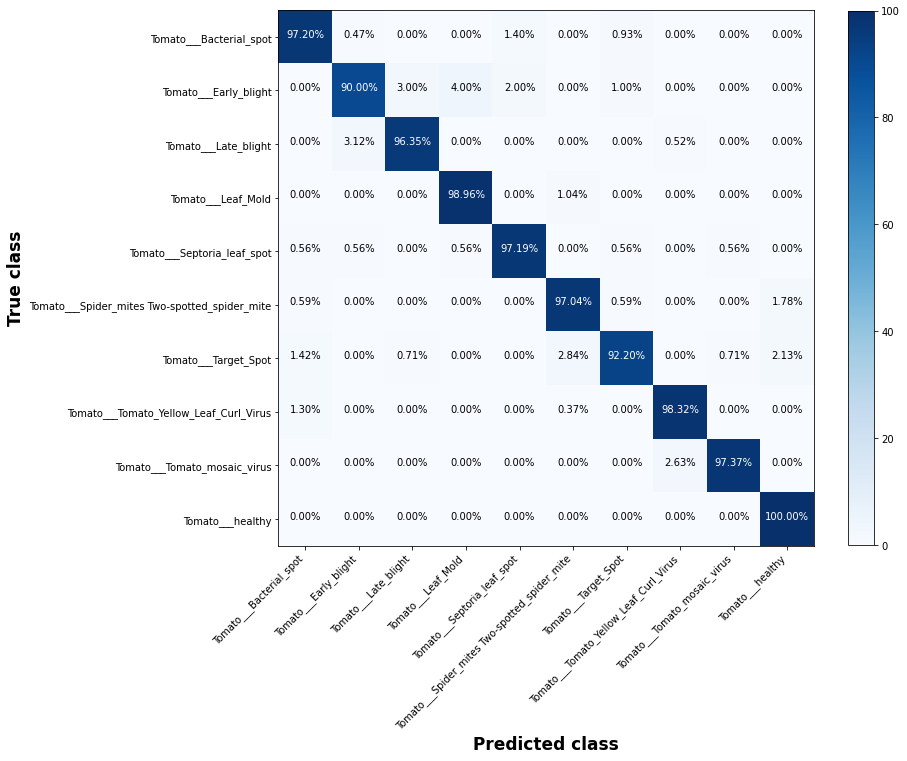

In [ ]:
import itertools

cmt = torch.zeros(10, 10, dtype=torch.int32) #10 is the number of classes

stacked = torch.stack(
    (
        test_labels
        ,test_preds.argmax(dim=1)
    )
    ,dim=1
)

for p in stacked:
    tl, pl = p.tolist()
    tl = int(tl)
    pl = int(pl)
    cmt[tl, pl] = cmt[tl, pl] + 1

#Plot CM
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels.cpu(), test_preds.argmax(dim=1).cpu())
print(cm)

plt.figure(figsize=(12, 12))
plot_confusion_matrix(cm, test_dataset.classes, True, 'Confusion matrix', cmap=plt.cm.Blues)
plt.savefig(save_model_to + 'confusionMatrix.eps', format='eps', bbox_inches='tight')
plt.show()